In [1]:
import tensorflow as tf
from tensorflow.keras import layers, optimizers, regularizers, Model
from model_implementations import resnet
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d, convolve1d
from IPython.display import clear_output

In [2]:
if tf.config.list_physical_devices('GPU'):
    # enable memory growth instead of blocking whole VRAM
    physical_devices = tf.config.list_physical_devices('GPU')
    tf.config.set_visible_devices(physical_devices[0], 'GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.keras.utils.set_random_seed(2022)

2022-08-22 15:58:22.249144: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-22 15:58:22.249371: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-22 15:58:22.271177: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-22 15:58:22.271408: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-22 15:58:22.271912: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [3]:
datapoints = 2000
cl1 = 949
cl2 = 1049
lim = 50

nt = 500
nv = 50

xt = np.zeros([nt*2, datapoints])
xv = np.zeros([nv*2, datapoints])

peak_shapes = (2,8)
rng = np.random.default_rng(2022)
for i in range(nt):
    temp = np.zeros(datapoints)
    temp[cl1+rng.integers(0,50, endpoint=True)] = 1.
    temp = gaussian_filter1d(temp, rng.uniform(*peak_shapes), 
                                     mode='constant')
    xt[i] = temp/np.max(temp) * rng.uniform(0.8, 1.2)
    temp = np.zeros(datapoints)
    temp[cl2-rng.integers(0,50, endpoint=False)] = 1.
    temp = gaussian_filter1d(temp, rng.uniform(*peak_shapes), 
                                     mode='constant')
    xt[nt+i] = temp/np.max(temp) * rng.uniform(0.8, 1.2)
for i in range(nv):
    temp = np.zeros(datapoints)
    temp[cl1+rng.integers(0,50, endpoint=True)] = 1.
    temp = gaussian_filter1d(temp, rng.uniform(*peak_shapes), 
                                     mode='constant')
    xv[i] = temp/np.max(temp) * rng.uniform(0.7, 1.3)
    temp = np.zeros(datapoints)
    temp[cl2-rng.integers(0,50, endpoint=False)] = 1.
    temp = gaussian_filter1d(temp, rng.uniform(*peak_shapes), 
                                     mode='constant')
    xv[nv+i] = temp/np.max(temp) * rng.uniform(0.7, 1.3)

In [4]:
yt = np.repeat(np.array([0,1]), nt, axis=0)
yv = np.repeat(np.array([0,1]), nv, axis=0)

In [5]:
pos_train = np.argmax(xt, axis=1)
hi_train = np.max(xt, axis=1)

In [6]:
plt.rcParams['font.size'] = 14

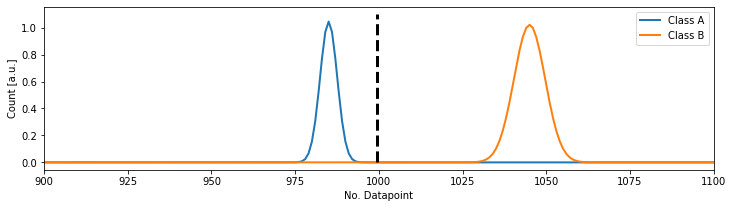

In [7]:
plt.figure(figsize=(12,3),)
plt.plot(xt[0], lw=2, c='C0', label='Class A')
plt.plot(xt[-7], lw=2, c='C1', label='Class B')
plt.plot([999.5,999.5],[0.,1.1],'--', lw=3, c='black')
plt.xlim(900,1100)
plt.legend()
plt.ylabel('Count [a.u.]')
plt.xlabel('No. Datapoint')
#plt.savefig('positional_spectra.png', dpi=500, bbox_inches='tight')
plt.show()

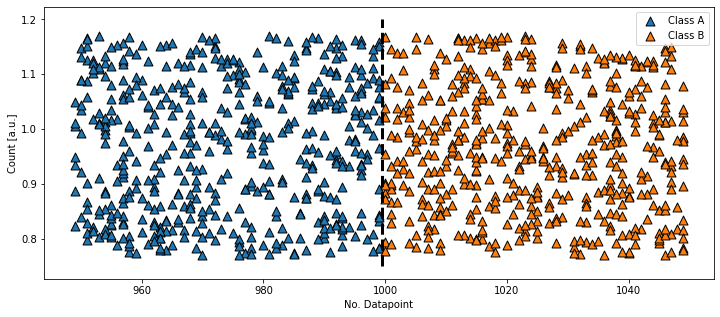

In [8]:
plt.figure(figsize=(12,5))
plt.scatter(pos_train[:nt], hi_train[:nt]-.03, s=80, marker='^', edgecolors='black', c='C0', label='Class A')
plt.scatter(pos_train[nt:], hi_train[nt:]-.03, s=80, marker='^', edgecolors='black', c='C1', label='Class B')
plt.plot([999.5,999.5],[.75,1.2],'--', lw=3, c='black')
plt.legend()
plt.ylabel('Count [a.u.]')
plt.xlabel('No. Datapoint')
#plt.savefig('positional_points.png', dpi=500, bbox_inches='tight')
plt.show()

In [9]:
class CustomProg(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.best_val = 1e5
        self.best_epoch_no = 0
        self.best_log = ''
        
    def on_epoch_end(self, epoch, logs=None):
        if logs['val_loss'] < self.best_val:
            self.best_val = logs['val_loss']
            self.best_epoch_no = epoch
            self.best_log = ' - '.join(f'{k}: {round(v, 4)}' for k,v in logs.items())
        clear_output(wait=True)
        print(f'Epoch {epoch}:', ' - '.join(f'{k}: {round(v, 4)}' for k,v in logs.items()))
        print(f'Best {self.best_epoch_no}: {self.best_log}')

In [10]:
model1 = resnet(input_size=2000, classes=2, batch_norm=False)
model1.fit(xt, yt, batch_size=256, epochs=50, verbose=0, 
          callbacks=[CustomProg(), tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)],
          validation_data=(xv, yv), shuffle=True)

Epoch 49: loss: 0.0001 - sparse_categorical_accuracy: 1.0 - val_loss: 0.0 - val_sparse_categorical_accuracy: 1.0
Best 45: loss: 0.0001 - sparse_categorical_accuracy: 1.0 - val_loss: 0.0 - val_sparse_categorical_accuracy: 1.0


In [11]:
xe = np.zeros([10*2, datapoints])
his = np.linspace(0.4,1.6,10,endpoint=False)
for i in range(20):
    pos = 999 if i < 10 else 1000
    xe[i,pos] = 1
    xe[i] = gaussian_filter1d(xe[i], 10, mode='constant') 
    xe[i] = xe[i]/np.max(xe[i])*his[(i % 10)]
ye = np.repeat(np.array([0,1]), 10, axis=0)

In [12]:
model1.evaluate(xe,ye)

1/1 [==============================] - 0s 52ms/step - loss: 1.4174 - sparse_categorical_accuracy: 0.5000


[1.417361855506897, 0.5]

In [13]:
np.round(model1.predict(xe), 2)

array([[0.28, 0.72],
       [0.21, 0.79],
       [0.15, 0.85],
       [0.11, 0.89],
       [0.08, 0.92],
       [0.05, 0.95],
       [0.03, 0.97],
       [0.02, 0.98],
       [0.02, 0.98],
       [0.01, 0.99],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.  , 1.  ]], dtype=float32)

In [14]:
model2 = resnet(input_size=2000, classes=2, layer_num=1, batch_norm=False)
model2.fit(xt, yt, batch_size=256, epochs=50, verbose=0, 
          callbacks=[CustomProg(), tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)],
          validation_data=(xv, yv), shuffle=True)

Epoch 49: loss: 0.0036 - sparse_categorical_accuracy: 0.999 - val_loss: 0.0001 - val_sparse_categorical_accuracy: 1.0
Best 49: loss: 0.0036 - sparse_categorical_accuracy: 0.999 - val_loss: 0.0001 - val_sparse_categorical_accuracy: 1.0


In [15]:
model2.evaluate(xe,ye)

1/1 [==============================] - 0s 11ms/step - loss: 0.1428 - sparse_categorical_accuracy: 1.0000


[0.14276044070720673, 1.0]

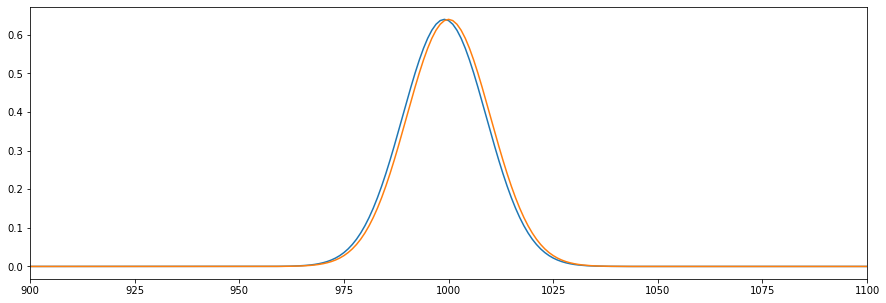

In [16]:
plt.figure(figsize=(15,5))
plt.plot(xe[2], c='C0')
plt.plot(xe[12], c='C1')
plt.xlim(900,1100)
plt.show()

In [17]:
def shrink_model(input_size=2000, layer_no=6,
                 pool_size=3):
    input_layer = layers.Input(shape=(input_size, 1),
                               name="input")
    x = input_layer
    for i in range(layer_no):
        x = layers.MaxPool1D(pool_size)(x)
    out = layers.Flatten()(x)
    model = Model(input_layer, out)
    return model

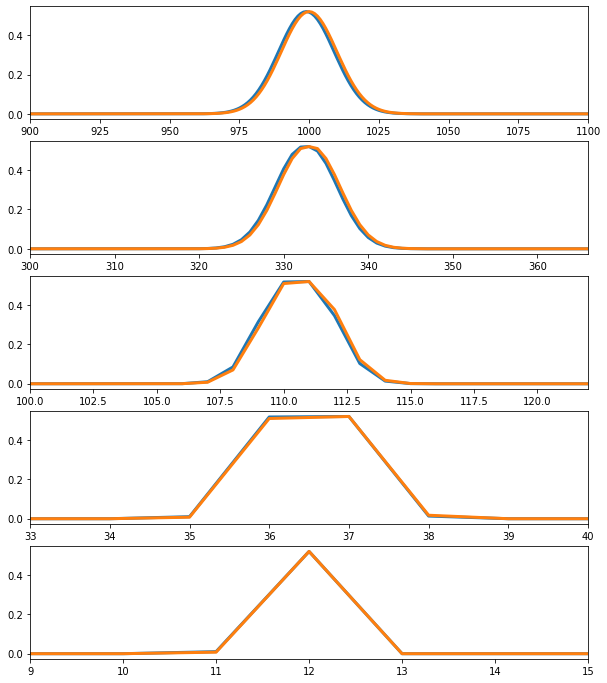

In [18]:
fig, ax = plt.subplots(5,1,figsize=(10,12))
for i in range(5):
    shrink = shrink_model(layer_no=i, pool_size=3)
    ax[i].plot(shrink.predict(xe[[1]])[0], lw=3, c='C0')
    ax[i].plot(shrink.predict(xe[[11]])[0], lw=3, c='C1')
    if i<4:
        ax[i].set_xlim(900//(3**i),1100//(3**i))
    if i == 4:
        ax[i].set_xlim(9,15)
plt.show()
#plt.savefig('positional_reduction.png', dpi=500, bbox_inches='tight')